In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re



In [ ]:
## Read the data ##

user_health_data = pd.read_csv('kidneydisease.csv')
user_health_data = user_health_data.sample(frac=1)
user_health_data.reset_index(drop=True, inplace=True)

In [ ]:
## Sanity Check
# - Data Sufficiency - not sufficient but this is dummy data
# - Type of problem ? - Classification
# - identify target column -  classification
# - Target distribution - user_health_data['classification'].value_counts()
# - Identify if class imbalance present or not - Yes but the ratio is acceptable as it is not that major
# - do we have columns that can help predict targets - Seem so as of Now

data_shape = user_health_data.shape

In [ ]:
print(data_shape)

(400, 26)


In [ ]:
user_health_data['classification'].value_counts()

classification
ckd       248
notckd    150
ckd\t       2
Name: count, dtype: int64

In [ ]:
## Exploratory Data Analysis ##

In [ ]:
user_health_data.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,74,56.0,90.0,1.015,2.0,0.0,abnormal,abnormal,notpresent,notpresent,...,29,6400,3.4,yes,no,no,good,no,no,ckd
1,206,60.0,70.0,1.010,1.0,0.0,NaN,normal,notpresent,notpresent,...,41,NaN,NaN,yes,no,no,good,no,no,ckd
2,5,60.0,90.0,1.015,3.0,0.0,NaN,NaN,notpresent,notpresent,...,39,7800,4.4,yes,yes,no,good,yes,no,ckd
3,73,NaN,100.0,1.015,2.0,0.0,abnormal,abnormal,notpresent,notpresent,...,14,6300,NaN,yes,no,no,good,yes,yes,ckd
4,126,70.0,90.0,1.015,0.0,0.0,NaN,normal,notpresent,notpresent,...,37,8200,4.5,yes,yes,no,poor,yes,no,ckd


In [ ]:
##  There seems to be issue with pcv, wc and rcv - type
user_health_data.dtypes

id                  int64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                object
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object

In [ ]:
## Data has missing values

In [ ]:
user_health_data.isnull().sum()

id                  0
age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                70
wc                105
rc                130
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64

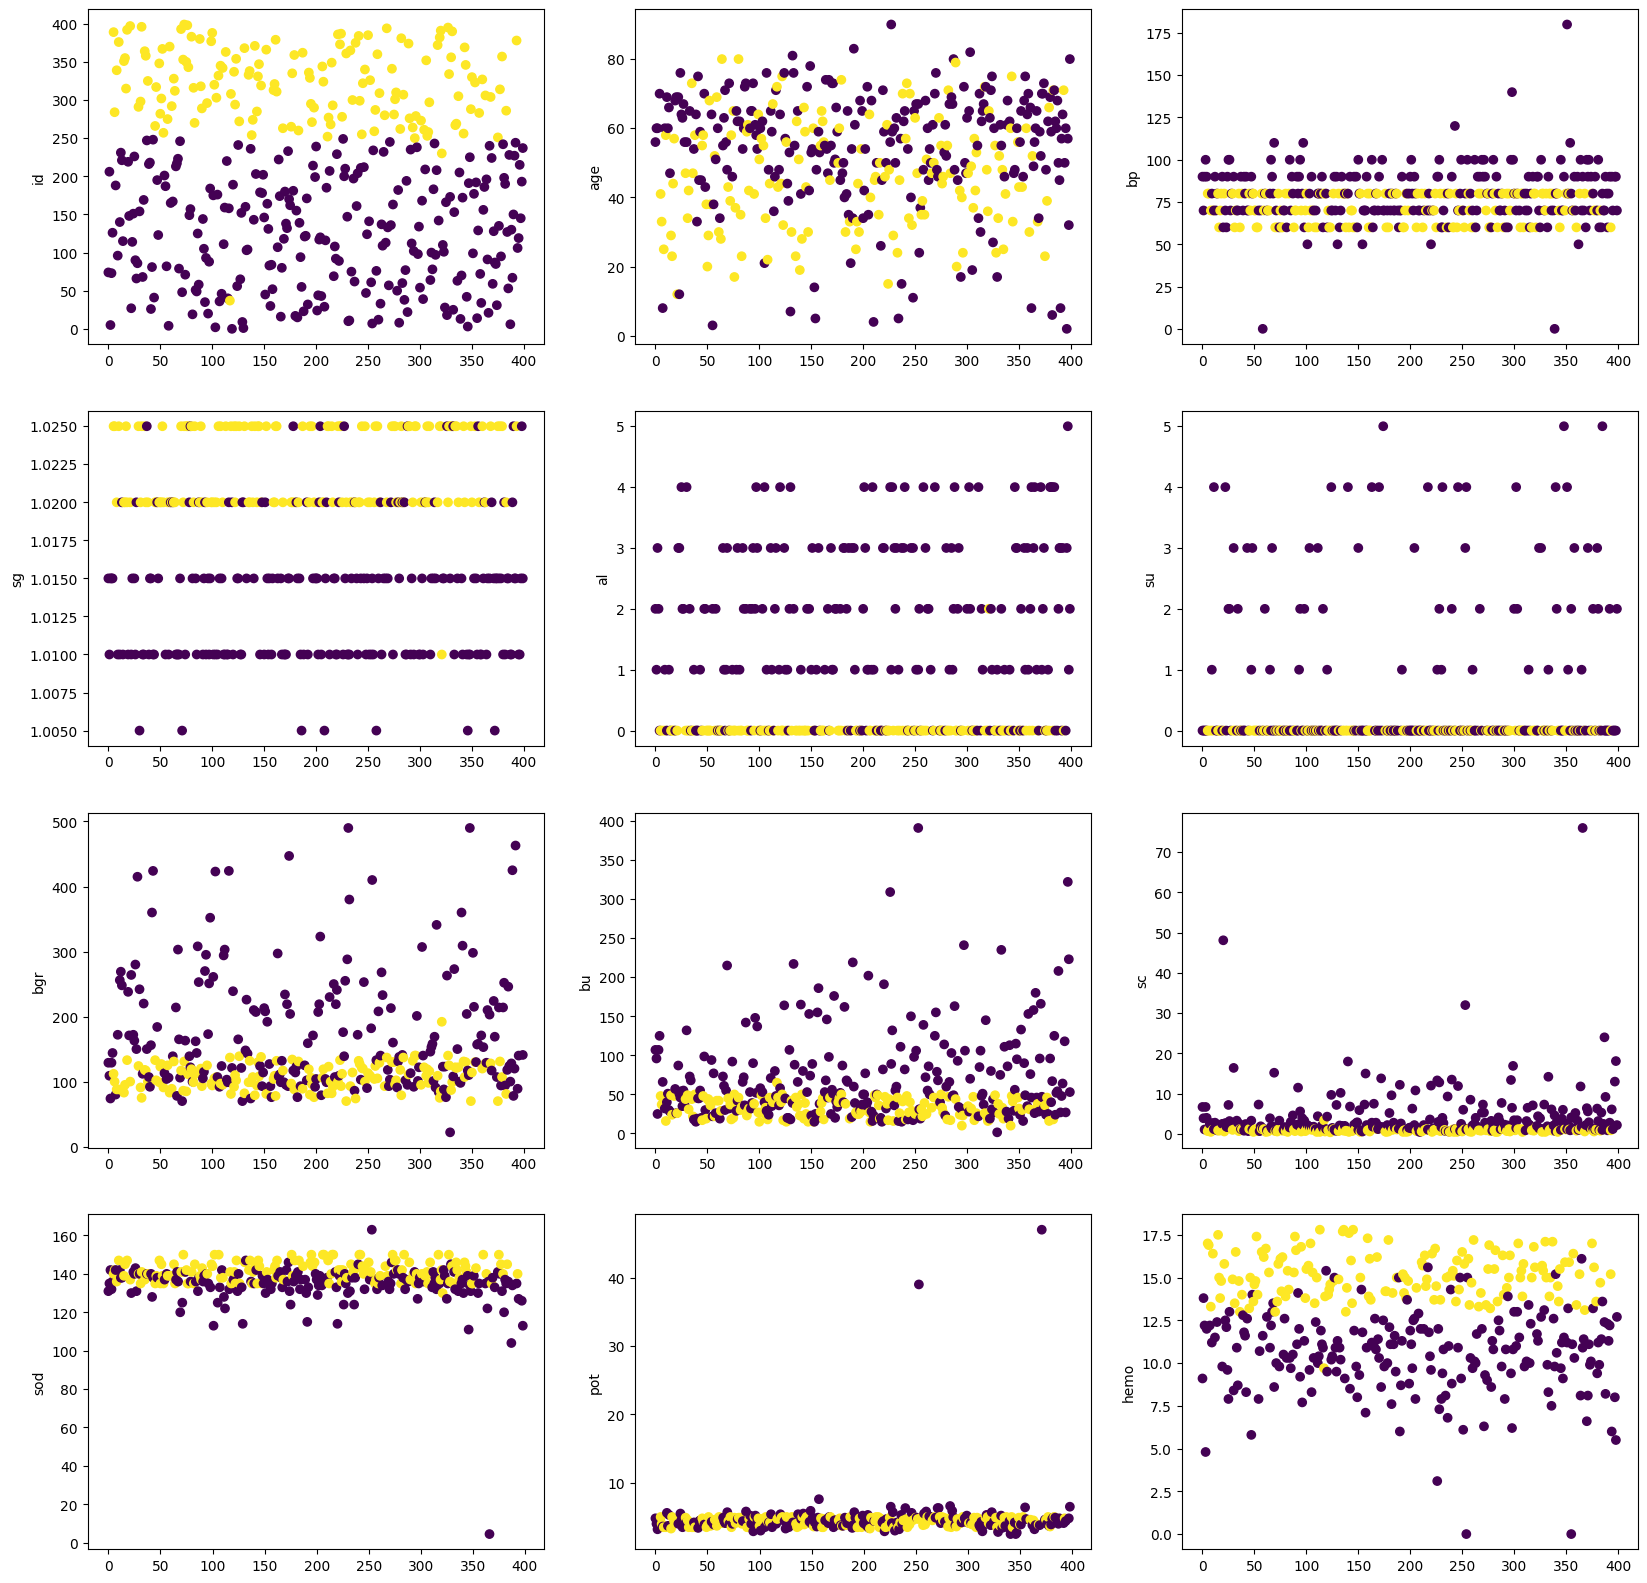

In [ ]:
### check for outliers

#### Visualizing numeric columns ######

numeric_cols = user_health_data.select_dtypes(include = np.number) ### selects numeric columns

column_names = list(numeric_cols.columns)

col_index = 0

plot_rows = 4
plot_cols = 3

fig, ax = plt.subplots(nrows = plot_rows,ncols=plot_cols,figsize = (20,20))

for row_count in range(plot_rows):
    for col_count in range(plot_cols):
        ax[row_count][col_count].scatter(y = numeric_cols[column_names[col_index]],x=numeric_cols.index, c= [0 if x == 'ckd' else 1 for x in user_health_data['classification']])
        ax[row_count][col_count].set_ylabel(column_names[col_index])
        col_index = col_index + 1

#### INSIGHTS #####
# Id column can be dropped
# There are persons with BP and hemo=0.. consider them as missing values and impute them
# SG, AL, SU are behaving more like a categorical column as it takes only specific values
# There is one customer with sodium level 0

In [ ]:
numeric_cols.corr()

,id,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo
id,1.000000,-0.185308,-0.184775,0.642156,-0.541993,-0.283416,-0.338673,-0.307175,-0.268683,0.364251,-0.092347,0.641736
age,-0.185308,1.000000,0.136910,-0.191096,0.122091,0.220866,0.244992,0.196985,0.132531,-0.100046,0.058377,-0.170304
bp,-0.184775,0.136910,1.000000,-0.183878,0.141488,0.219672,0.164441,0.176781,0.136570,-0.107258,0.077796,-0.259716
sg,0.642156,-0.191096,-0.183878,1.000000,-0.469760,-0.296234,-0.374710,-0.314295,-0.361473,0.412190,-0.072787,0.585876
al,-0.541993,0.122091,0.141488,-0.469760,1.000000,0.269305,0.379464,0.453528,0.399198,-0.459896,0.129038,-0.620588
su,-0.283416,0.220866,0.219672,-0.296234,0.269305,1.000000,0.717827,0.168583,0.223244,-0.131776,0.219450,-0.266080
bgr,-0.338673,0.244992,0.164441,-0.374710,0.379464,0.717827,1.000000,0.143322,0.114875,-0.267848,0.066966,-0.335866
bu,-0.307175,0.196985,0.176781,-0.314295,0.453528,0.168583,0.143322,1.000000,0.586368,-0.323054,0.357049,-0.581301
sc,-0.268683,0.132531,0.136570,-0.361473,0.399198,0.223244,0.114875,0.586368,1.000000,-0.690158,0.326107,-0.381504
sod,0.364251,-0.100046,-0.107258,0.412190,-0.459896,-0.131776,-0.267848,-0.323054,-0.690158,1.000000,0.097887,0.362273


In [ ]:
# Lets Analyze Categorical Columns
##INSIGHTS##
# dm , cad , classification columns need preprocessing
# pcv, wc , rc are numerical columns showing as object type need to check on that

categorical_data = user_health_data.select_dtypes(include = 'object')
categorical_colnames = list(categorical_data.columns)

In [ ]:
for col in categorical_colnames:
  print('**************************************')
  print(col)
  print(categorical_data[col].value_counts())

**************************************
rbc
rbc
normal      201
abnormal     47
Name: count, dtype: int64
**************************************
pc
pc
normal      259
abnormal     76
Name: count, dtype: int64
**************************************
pcc
pcc
notpresent    354
present        42
Name: count, dtype: int64
**************************************
ba
ba
notpresent    374
present        22
Name: count, dtype: int64
**************************************
pcv
pcv
52      21
41      21
48      19
44      19
40      16
43      14
42      13
45      13
50      12
33      12
32      12
36      12
28      12
37      11
34      11
30       9
29       9
46       9
35       9
31       8
24       7
39       7
26       6
38       5
49       4
54       4
47       4
51       4
53       4
22       3
25       3
27       3
23       2
19       2
\t?      1
14       1
\t43     1
21       1
9        1
20       1
18       1
16       1
17       1
15       1
Name: count, dtype: int64
*******************

In [ ]:
## Preprocessing ##

# - Need to convert numeric column to numeric that are object types
## Identify non-numeric values making it object type and do the treatment

In [ ]:
def identify_non_numeric(series_):
  non_numeric = []
  for elem in series_:
    try:
      float(elem)
    except:
      non_numeric.append(elem)
  return non_numeric


In [ ]:
for col in ['pcv','wc','rc']:
  non_numeric_elem = identify_non_numeric(categorical_data[col])
  print('************************************************')
  print(col)
  print(non_numeric_elem)

************************************************
pcv
['\t?']
************************************************
wc
['\t?']
************************************************
rc
['\t?']


In [ ]:
for col in ['pcv','wc','rc']:
  user_health_data[col] = pd.to_numeric(user_health_data[col], errors = 'coerce')

In [ ]:
user_health_data.dtypes

id                  int64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv               float64
wc                float64
rc                float64
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object

In [ ]:
## Processing the categorical column ##

user_health_data['dm'].value_counts()

dm
no       258
yes      134
\tno       3
\tyes      2
 yes       1
Name: count, dtype: int64

In [ ]:
user_health_data['cad'].value_counts()

cad
no      362
yes      34
\tno      2
Name: count, dtype: int64

In [ ]:
user_health_data['classification'].value_counts()

classification
ckd       248
notckd    150
ckd\t       2
Name: count, dtype: int64

In [ ]:
def convert(input_str):
  '''to convert the white lines to empty string saving the output as string in output variable'''
  output = re.sub(r'^\s+', '', str(input_str))
  return output

In [ ]:
for series in ['dm','cad']:
  user_health_data[series] = user_health_data[series].apply(lambda x: convert(x) )
  print('**********************************************************************')
  print(user_health_data[series].value_counts())

**********************************************************************
dm
no     261
yes    137
nan      2
Name: count, dtype: int64
**********************************************************************
cad
no     364
yes     34
nan      2
Name: count, dtype: int64


In [ ]:
def convert_target(input_str):
  output = re.sub(r'\s+$', '', str(input_str))
  return output

In [ ]:
user_health_data['classification'] = user_health_data['classification'].apply(lambda x: convert_target(x))
print(user_health_data['classification'].value_counts())

classification
ckd       250
notckd    150
Name: count, dtype: int64


In [ ]:
## Preprocessing - 2

user_health_data.drop(['id'], axis = 1 , inplace = True)

In [ ]:
user_health_data.loc[user_health_data['bp']<25, 'bp'] = np.nan
user_health_data.loc[user_health_data['bp']<25, 'hemo'] = np.nan

In [ ]:
## Preprocessing Missing Value

user_health_data.isnull().sum()

age                 9
bp                 14
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                71
wc                106
rc                131
htn                 2
dm                  0
cad                 0
appet               1
pe                  1
ane                 1
classification      0
dtype: int64

In [ ]:
## Percentage of missing value (column wise)
user_health_data.isnull().sum()/user_health_data.shape[0]*100

age                2.25
bp                 3.50
sg                11.75
al                11.50
su                12.25
rbc               38.00
pc                16.25
pcc                1.00
ba                 1.00
bgr               11.00
bu                 4.75
sc                 4.25
sod               21.75
pot               22.00
hemo              13.00
pcv               17.75
wc                26.50
rc                32.75
htn                0.50
dm                 0.00
cad                0.00
appet              0.25
pe                 0.25
ane                0.25
classification     0.00
dtype: float64

In [ ]:
## percentage of missing value (row wise)

missing_value_row = user_health_data.isnull().sum(axis=1)/user_health_data.shape[1]*100

In [ ]:
missing_value_row.describe() ## 44% is small value , if the missing value would be 90% or more we could have dropped that row but here we need to do imputation only

count    400.000000
mean      10.100000
std       11.727482
min        0.000000
25%        0.000000
50%        4.000000
75%       16.000000
max       44.000000
dtype: float64

In [ ]:
## ANALYSIS OF COLUMNS ##

user_health_data['age'].isnull().sum()

9

In [ ]:
user_health_data['age'].describe()

count    391.000000
mean      51.483376
std       17.169714
min        2.000000
25%       42.000000
50%       55.000000
75%       64.500000
max       90.000000
Name: age, dtype: float64

<ipython-input-35-67a8fcced371>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(user_health_data['age'])


<Axes: xlabel='age', ylabel='Density'>

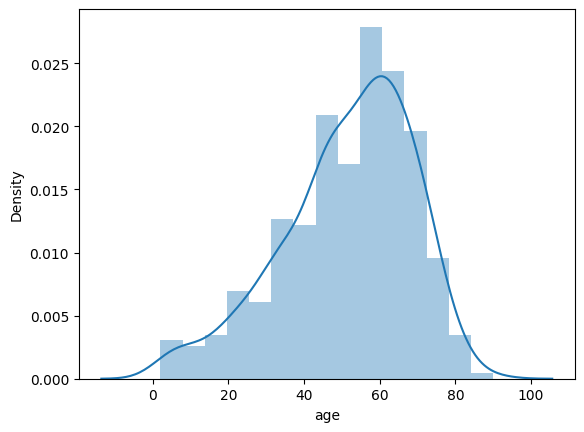

In [ ]:
sns.distplot(user_health_data['age'])

In [ ]:
## we can see that it is a slightly left skewed normally distributed and for 9 missing value we can replace it with mean value

user_health_data.loc[user_health_data['age'].isnull(),'age'] = 55

In [ ]:
## Analysis of BP column

user_health_data['bp'].isnull().sum()

14

<ipython-input-38-1bf4e17a6cb6>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(user_health_data['bp'])


<Axes: xlabel='bp', ylabel='Density'>

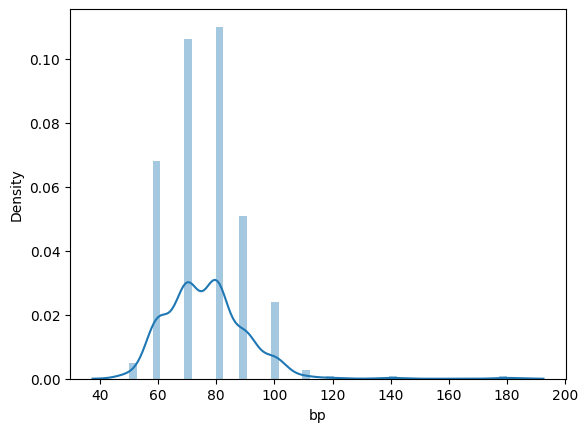

In [ ]:
sns.distplot(user_health_data['bp'])

In [ ]:
user_health_data['bp'].describe()

count    386.000000
mean      76.476684
std       13.713989
min       50.000000
25%       70.000000
50%       80.000000
75%       80.000000
max      180.000000
Name: bp, dtype: float64

In [ ]:
user_health_data.loc[user_health_data['bp'].isnull(),'bp'] = 80

In [ ]:
### ANALYSIS OF HTN/DM/CAD/APPET/PE MISSING VALUES ####
user_health_data['htn'].value_counts()

htn
no     251
yes    147
Name: count, dtype: int64

In [ ]:
user_health_data.loc[user_health_data['htn'].isnull(),'htn'] = 'no'

In [ ]:
user_health_data['dm'].value_counts()

dm
no     261
yes    137
nan      2
Name: count, dtype: int64

In [ ]:
user_health_data.loc[user_health_data['dm'] == 'nan','dm'] = 'no'

In [ ]:
user_health_data['cad'].value_counts()

cad
no     364
yes     34
nan      2
Name: count, dtype: int64

In [ ]:
user_health_data.loc[user_health_data['cad'] == 'nan','cad'] = 'no'

In [ ]:
user_health_data['appet'].value_counts()

appet
good    317
poor     82
Name: count, dtype: int64

In [ ]:
user_health_data['appet'].fillna('good',inplace = True)

In [ ]:
user_health_data['pe'].value_counts()

pe
no     323
yes     76
Name: count, dtype: int64

In [ ]:
user_health_data['pe'].fillna('no',inplace = True)

In [ ]:
user_health_data['ane'].value_counts()

ane
no     339
yes     60
Name: count, dtype: int64

In [ ]:
user_health_data['ane'].fillna('no',inplace = True)

In [ ]:
### ANALYSIS OF PCC COLUMN ###

user_health_data.loc[user_health_data['pcc'].isnull(),:]

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
63,28.0,70.0,1.02,0.0,0.0,normal,normal,NaN,NaN,131.0,...,45.0,8600.0,6.5,no,no,no,good,no,no,notckd
82,35.0,80.0,1.02,0.0,0.0,normal,normal,NaN,NaN,99.0,...,48.0,5000.0,5.2,no,no,no,good,no,no,notckd
198,54.0,70.0,1.02,0.0,0.0,NaN,NaN,NaN,NaN,76.0,...,52.0,8400.0,5.9,no,no,no,good,no,no,notckd
235,45.0,60.0,1.02,0.0,0.0,normal,normal,NaN,NaN,114.0,...,43.0,9200.0,5.8,no,no,no,good,no,no,notckd


In [ ]:
pd.crosstab(user_health_data['pc'],user_health_data['pcc'])

pcc,notpresent,present
pc,,
abnormal,43,33
normal,248,8


In [ ]:
## from above we can conclude that there is high chances of PCC to be notpresent whenever pc is normal also notpresent is dominating value
user_health_data['pcc'].value_counts()

pcc
notpresent    354
present        42
Name: count, dtype: int64

In [ ]:
user_health_data.loc[user_health_data['pcc'].isnull(), 'pcc'] = 'notpresent'

In [ ]:
user_health_data['ba'].value_counts()

ba
notpresent    374
present        22
Name: count, dtype: int64

In [ ]:
user_health_data.loc[user_health_data['ba'].isnull(), 'ba'] = 'notpresent'

In [ ]:
## ANALYSIS OF BLOOD UREA ###

In [ ]:
user_health_data['bu'].describe()

count    381.000000
mean      57.425722
std       50.503006
min        1.500000
25%       27.000000
50%       42.000000
75%       66.000000
max      391.000000
Name: bu, dtype: float64

<ipython-input-61-3bea5d83b03d>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(user_health_data['bu'])


<Axes: xlabel='bu', ylabel='Density'>

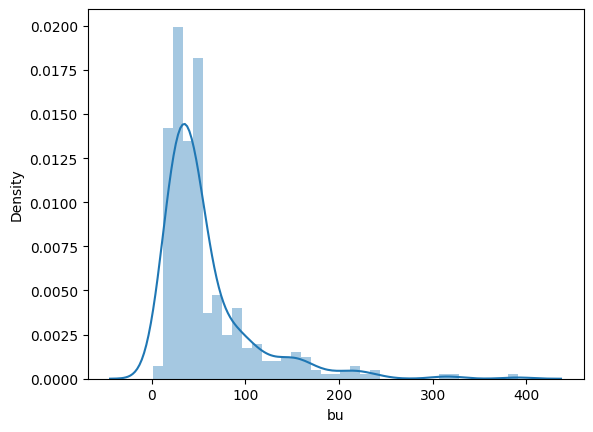

In [ ]:
sns.distplot(user_health_data['bu'])

In [ ]:
user_health_data.loc[user_health_data['bu'].isnull(),:]

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
17,44.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,NaN,...,48.0,7800.0,4.4,no,no,no,good,no,no,notckd
60,60.0,80.0,1.020,0.0,2.0,NaN,NaN,notpresent,notpresent,NaN,...,NaN,NaN,NaN,no,yes,no,good,no,no,ckd
64,80.0,70.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,NaN,...,48.0,6300.0,6.1,no,no,no,good,no,no,notckd
114,36.0,80.0,1.010,0.0,0.0,NaN,normal,notpresent,notpresent,103.0,...,36.0,8800.0,NaN,no,no,no,good,no,no,ckd
186,35.0,80.0,1.005,3.0,0.0,abnormal,normal,notpresent,notpresent,NaN,...,28.0,NaN,NaN,no,no,no,good,yes,no,ckd
188,21.0,70.0,1.010,0.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,NaN,NaN,NaN,no,no,no,poor,no,yes,ckd
239,62.0,80.0,1.015,3.0,0.0,abnormal,NaN,notpresent,notpresent,NaN,...,42.0,10200.0,4.8,yes,yes,no,good,no,no,ckd
265,50.0,90.0,1.015,1.0,0.0,abnormal,abnormal,notpresent,notpresent,NaN,...,NaN,NaN,NaN,no,no,no,good,yes,no,ckd
267,61.0,90.0,1.015,0.0,2.0,NaN,normal,notpresent,notpresent,NaN,...,NaN,9800.0,NaN,no,yes,no,poor,no,yes,ckd
290,20.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,NaN,...,41.0,4500.0,5.5,no,no,no,good,no,no,notckd


<Axes: xlabel='ba', ylabel='bu'>

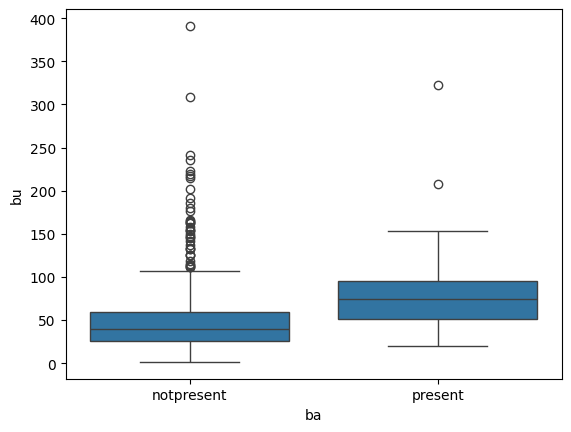

In [ ]:
sns.boxplot(x=user_health_data['ba'] , y = user_health_data['bu'])

In [ ]:
## When Bacteria is notpresent blood Urea mean value lies below 50 and when Bacteria is present blood Urea mean value lies somewhere between 50-100

In [ ]:
user_health_data['bu'].describe()

count    381.000000
mean      57.425722
std       50.503006
min        1.500000
25%       27.000000
50%       42.000000
75%       66.000000
max      391.000000
Name: bu, dtype: float64

In [ ]:
user_health_data.loc[user_health_data['ba']=='notpresent','bu'].median()

40.0

In [ ]:
user_health_data.loc[user_health_data['ba']=='present','bu'].median()

74.5

In [ ]:
user_health_data.loc[(user_health_data['bu'].isnull()) & (user_health_data['ba']=='notpresent'),'bu'] = 40

In [ ]:
user_health_data.loc[(user_health_data['bu'].isnull()) & (user_health_data['ba']=='present'),'bu'] = 74.5

<Axes: xlabel='ba', ylabel='sc'>

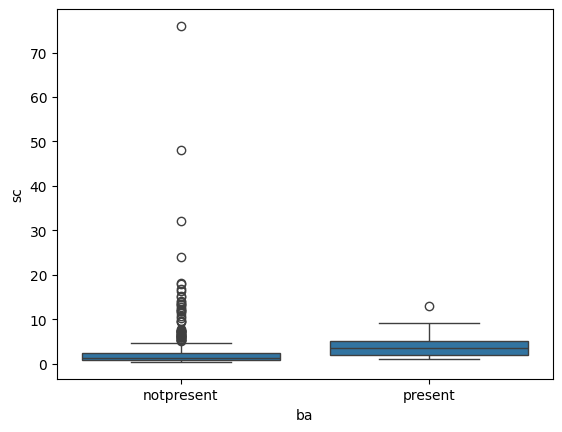

In [ ]:
## ANALYSIS OF SC column ##

sns.boxplot(x=user_health_data['ba'] , y = user_health_data['sc'])

In [ ]:
user_health_data.loc[user_health_data['ba']=='notpresent','sc'].median()

1.2

In [ ]:
user_health_data.loc[user_health_data['ba']=='present','sc'].median()

3.45

In [ ]:
user_health_data.loc[(user_health_data['sc'].isnull()) & (user_health_data['ba']=='notpresent'),'sc'] = 1.2
user_health_data.loc[(user_health_data['sc'].isnull()) & (user_health_data['ba']=='present'),'sc'] = 3.45

<ipython-input-74-f49c702108be>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(user_health_data['bgr'])


<Axes: xlabel='bgr', ylabel='Density'>

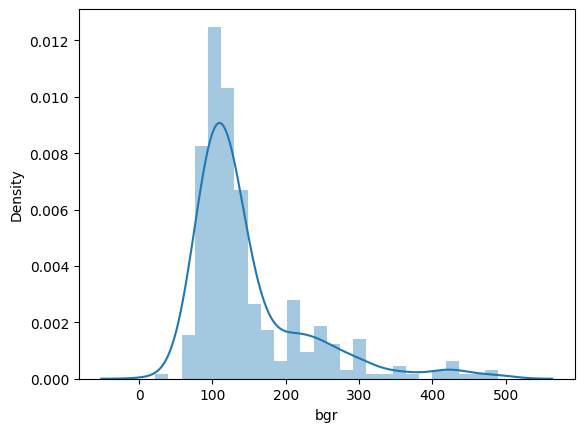

In [ ]:
## Analysis of BGR Column ##

sns.distplot(user_health_data['bgr'])

In [ ]:
user_health_data['bgr'].describe()

count    356.000000
mean     148.036517
std       79.281714
min       22.000000
25%       99.000000
50%      121.000000
75%      163.000000
max      490.000000
Name: bgr, dtype: float64

<Axes: xlabel='dm', ylabel='bgr'>

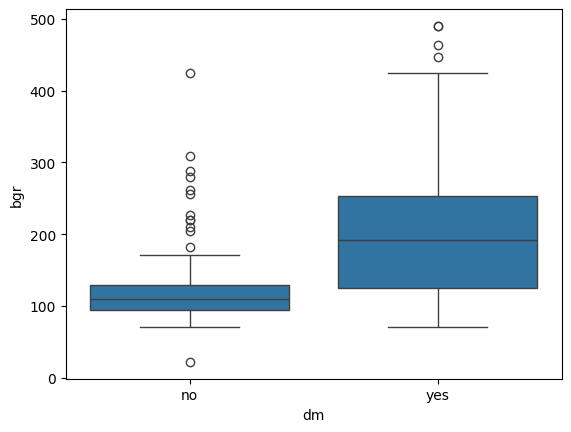

In [ ]:
## blood Glucose Level (bgr) and Diabetes Mellitus (DM) relation ##

sns.boxplot(x=user_health_data['dm'] , y = user_health_data['bgr'])

In [ ]:
user_health_data.loc[user_health_data['dm']=='no','bgr'].median()


109.0

In [ ]:
user_health_data.loc[user_health_data['dm']=='yes','bgr'].median()

192.0

In [ ]:
user_health_data.loc[(user_health_data['bgr'].isnull()) & (user_health_data['dm']=='no'),'bgr'] = 109
user_health_data.loc[(user_health_data['bgr'].isnull()) & (user_health_data['dm']=='yes'),'bgr'] = 192


<ipython-input-80-3ef0058965f5>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(user_health_data['al'])  ## more likely to be categorical column


<Axes: xlabel='al', ylabel='Density'>

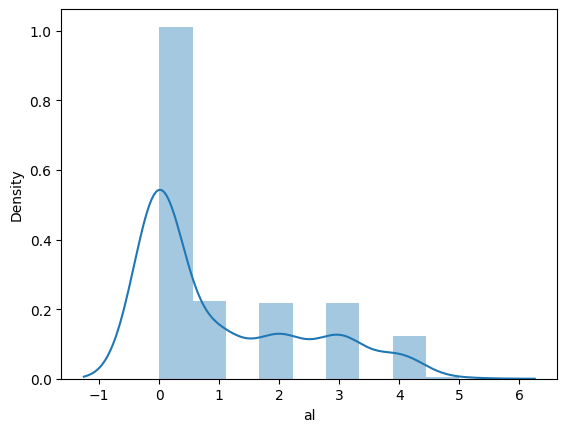

In [ ]:
## Analysing the al column ##
sns.distplot(user_health_data['al'])  ## more likely to be categorical column

In [ ]:
user_health_data['al'].value_counts()

al
0.0    199
1.0     44
2.0     43
3.0     43
4.0     24
5.0      1
Name: count, dtype: int64

In [ ]:
user_health_data.loc[user_health_data['al'].isnull(),'al'] = 0

<Axes: xlabel='sg', ylabel='sod'>

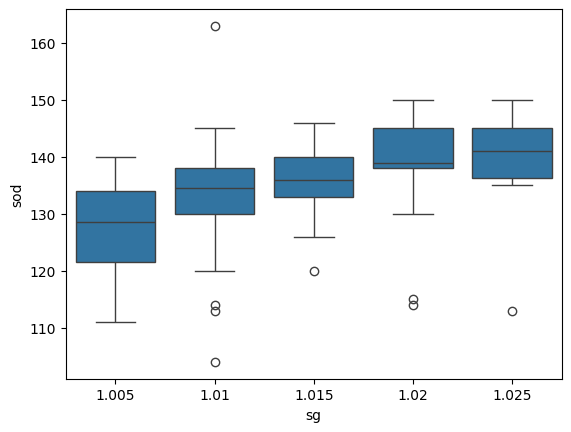

In [ ]:
## Specific Gravity (sg) relation with Sodium Level (sod) ##

sns.boxplot(x = user_health_data['sg'], y = user_health_data['sod'])

In [ ]:
median_sod_sg = user_health_data.groupby(by='sg')['sod'].median()
median_sod_sg_dict = median_sod_sg.to_dict()

In [ ]:
median_sod_sg_dict

{1.005: 128.5, 1.01: 134.5, 1.015: 136.0, 1.02: 139.0, 1.025: 141.0}

In [ ]:
x = user_health_data.loc[(user_health_data['sg'].isnull()) & (~(user_health_data['sod'].isnull())),:]
x[['sod','sg']]

,sod,sg
7,142.0,NaN
12,138.0,NaN
24,141.0,NaN
42,128.0,NaN
54,137.0,NaN
56,140.0,NaN
86,131.0,NaN
117,141.0,NaN
132,147.0,NaN
137,136.0,NaN


In [ ]:
def find_closest(x,median_dict):
  min_closest = 999999
  for key , value in median_dict.items():
    min_dist = abs(x-value)
    if min_dist<min_closest:
      min_closest = min_dist
      probable_sg = key
  return probable_sg

In [ ]:
output_sg = []
for elem in x['sod']:
  output_sg.append(find_closest(elem,median_sod_sg_dict))


In [ ]:
user_health_data.loc[(user_health_data['sg'].isnull()) & (~(user_health_data['sod'].isnull())),'sg'] = output_sg

In [ ]:
user_health_data['sg'].value_counts()

sg
1.020    112
1.025     92
1.010     91
1.015     79
1.005     16
Name: count, dtype: int64

In [ ]:
## for remaining 2.5 % missing value lets impute it with the mode value ##

user_health_data['sg'].fillna(1.020,inplace = True)

<ipython-input-92-713f1956f420>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(user_health_data['hemo'])


<Axes: xlabel='hemo', ylabel='Density'>

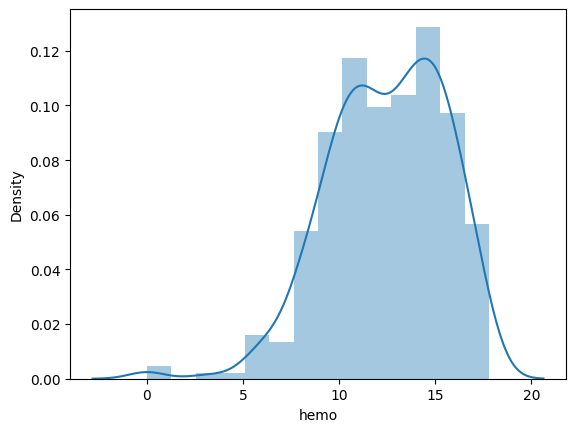

In [ ]:
## Ananlysis of Hemoglobin column ##

sns.distplot(user_health_data['hemo'])

<Axes: xlabel='hemo', ylabel='pcv'>

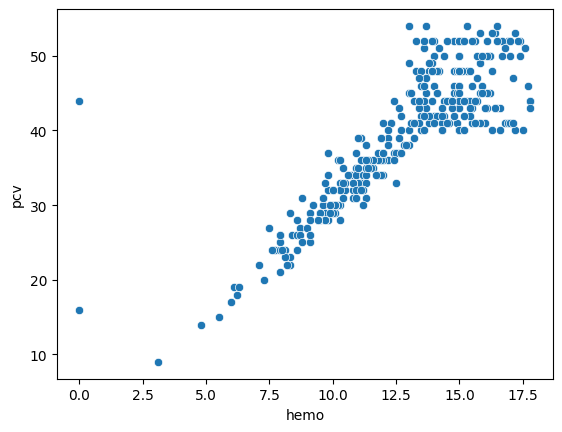

In [ ]:
## as per correlation found for hemo and pcv it is 86% correlated , lets generate a scatter plot for them ##

sns.scatterplot(x=user_health_data['hemo'],y=user_health_data['pcv'])

## after 40 of pcv the linear relationship between pcv and hemo is distorted

In [ ]:
user_health_data.loc[user_health_data['hemo'].isnull() &(~(user_health_data['pcv'].isnull())),:]

## this analysis is not usefull as the presence of PCV is only twice where hemo is null

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
63,28.0,70.0,1.02,0.0,0.0,normal,normal,notpresent,notpresent,131.0,...,45.0,8600.0,6.5,no,no,no,good,no,no,notckd
350,43.0,80.0,1.02,0.0,0.0,normal,normal,notpresent,notpresent,114.0,...,42.0,NaN,NaN,no,no,no,good,no,no,notckd


<Axes: xlabel='hemo', ylabel='rc'>

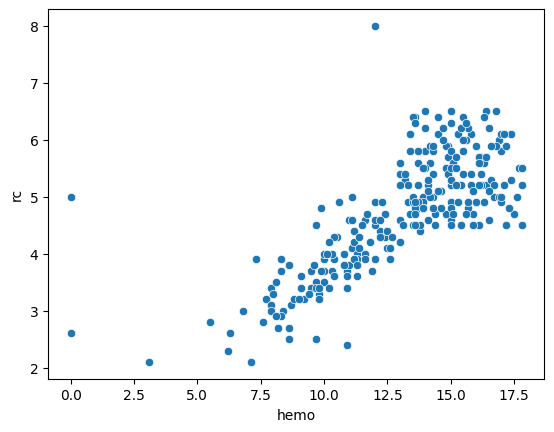

In [ ]:
## as per correlation found for hemo and rc it is 76% correlated , lets generate a scatter plot for them ##
sns.scatterplot(x=user_health_data['hemo'],y=user_health_data['rc'])


In [ ]:
user_health_data.loc[user_health_data['hemo'].isnull() &(~(user_health_data['rc'].isnull())),:]
## this analysis is not usefull as the presence of rc is only 4 times where hemo is null

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
63,28.0,70.0,1.02,0.0,0.0,normal,normal,notpresent,notpresent,131.0,...,45.0,8600.0,6.5,no,no,no,good,no,no,notckd
97,58.0,110.0,1.01,4.0,0.0,NaN,normal,notpresent,notpresent,251.0,...,NaN,13200.0,4.7,yes,yes,no,good,no,no,ckd
101,60.0,50.0,1.01,0.0,0.0,NaN,normal,notpresent,notpresent,261.0,...,NaN,4200.0,3.4,yes,no,no,good,no,no,ckd
233,24.0,80.0,1.02,0.0,0.0,normal,normal,notpresent,notpresent,93.0,...,NaN,10700.0,6.3,no,no,no,good,no,no,notckd


<Axes: xlabel='rbc', ylabel='hemo'>

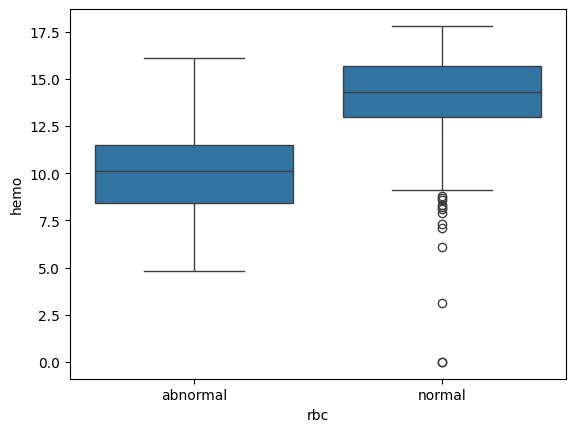

In [ ]:
## Lets compare red blood cell with hemoglobin as hemoglobin get impacted with blood cell

sns.boxplot(x=user_health_data['rbc'],y=user_health_data['hemo'])

<Axes: xlabel='pcc', ylabel='hemo'>

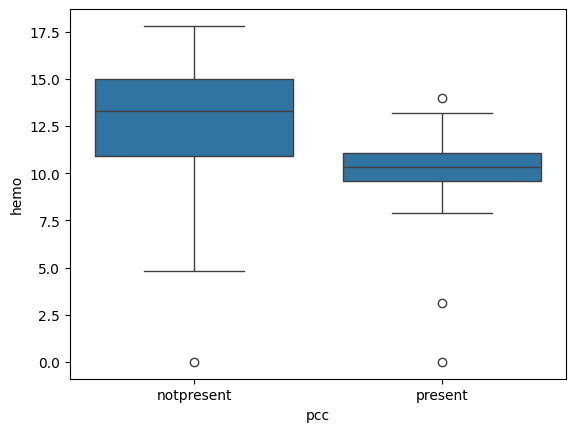

In [ ]:
## rbc is also have missing value so lets check with pcc relation with hemo also pcc was least imputed as well
sns.boxplot(x=user_health_data['pcc'],y=user_health_data['hemo'])

In [ ]:
user_health_data['pcc'].value_counts()
## present value is very less in comparision with notpresent so we can't depend on this pcc for finding hemo

pcc
notpresent    358
present        42
Name: count, dtype: int64

<Axes: xlabel='htn', ylabel='hemo'>

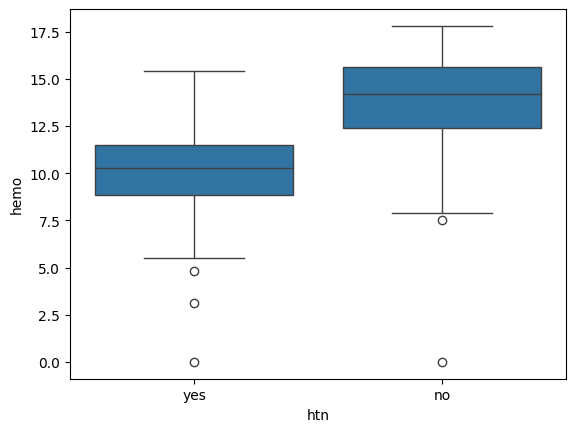

In [ ]:
sns.boxplot(x=user_health_data['htn'],y=user_health_data['hemo'])  ## good difference in data with respect to hypertension (htn) and hemo

In [ ]:
user_health_data['htn'].value_counts()
## we can go for htn as this is giving us proper ration of yes and no

htn
no     253
yes    147
Name: count, dtype: int64

In [ ]:
user_health_data.loc[user_health_data['htn']=='no','hemo'].median()

14.2

In [ ]:
user_health_data.loc[user_health_data['htn']=='yes','hemo'].median()

10.25

In [ ]:
user_health_data.loc[(user_health_data['hemo'].isnull()) & (user_health_data['htn']=='no'),'hemo'] = 14.2
user_health_data.loc[(user_health_data['hemo'].isnull()) & (user_health_data['htn']=='yes'),'hemo'] = 10.25

In [ ]:
## Analysis of Sugar in Urine (su) ##

user_health_data['su'].value_counts()

su
0.0    290
2.0     18
3.0     14
1.0     13
4.0     13
5.0      3
Name: count, dtype: int64

In [ ]:
## tried to find relation with other fields but couldn't find much so we can replace missing value with 0.0

user_health_data['su'].fillna(0.0,inplace = True)

In [ ]:
## we can drop pcv and rc for time being as they are showing good correlation with hemo and we have hemo already
## we can drop wc and pot as these are mixture and doesn't seems to give much clarity
## We will be dropping columns those missing values are greater than 0 this is not permanent , we can come back and add one by one column to see if that make any difference in learning

In [ ]:
user_health_data.dropna(axis = 1 , inplace = True)

In [ ]:
user_health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             400 non-null    float64
 1   bp              400 non-null    float64
 2   sg              400 non-null    float64
 3   al              400 non-null    float64
 4   su              400 non-null    float64
 5   pcc             400 non-null    object 
 6   ba              400 non-null    object 
 7   bgr             400 non-null    float64
 8   bu              400 non-null    float64
 9   sc              400 non-null    float64
 10  hemo            400 non-null    float64
 11  htn             400 non-null    object 
 12  dm              400 non-null    object 
 13  cad             400 non-null    object 
 14  appet           400 non-null    object 
 15  pe              400 non-null    object 
 16  ane             400 non-null    object 
 17  classification  400 non-null    obj

In [ ]:
## Coverting Object columns to Numeric ##

obj_cols = user_health_data.select_dtypes('object')
obj_cols.drop(['classification'],axis = 1 , inplace = True)
obj_col_names = obj_cols.columns

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
ohe.fit(obj_cols) ## Look at every columns and identify unique value in the existing columns
new_cols = ohe.get_feature_names_out(obj_col_names) ## takes the columns name as parameter and output the new column names generated after transformation
transform_cols = ohe.transform(obj_cols).toarray()  ## create the dummy columns
transform_cols = pd.DataFrame(transform_cols, columns = new_cols)

In [ ]:
user_health_data.drop(obj_col_names,axis = 1 , inplace = True)

In [ ]:
user_health_data = pd.concat([user_health_data,transform_cols],axis = 1 )

In [ ]:
user_health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             400 non-null    float64
 1   bp              400 non-null    float64
 2   sg              400 non-null    float64
 3   al              400 non-null    float64
 4   su              400 non-null    float64
 5   bgr             400 non-null    float64
 6   bu              400 non-null    float64
 7   sc              400 non-null    float64
 8   hemo            400 non-null    float64
 9   classification  400 non-null    object 
 10  pcc_notpresent  400 non-null    float64
 11  pcc_present     400 non-null    float64
 12  ba_notpresent   400 non-null    float64
 13  ba_present      400 non-null    float64
 14  htn_no          400 non-null    float64
 15  htn_yes         400 non-null    float64
 16  dm_no           400 non-null    float64
 17  dm_yes          400 non-null    flo

In [ ]:
user_health_data.head()

,age,bp,sg,al,su,bgr,bu,sc,hemo,classification,...,dm_no,dm_yes,cad_no,cad_yes,appet_good,appet_poor,pe_no,pe_yes,ane_no,ane_yes
0,56.0,90.0,1.015,2.0,0.0,129.0,107.0,6.7,9.1,ckd,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,60.0,70.0,1.010,1.0,0.0,109.0,96.0,3.9,13.8,ckd,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,60.0,90.0,1.015,3.0,0.0,74.0,25.0,1.1,12.2,ckd,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,55.0,100.0,1.015,2.0,0.0,129.0,107.0,6.7,4.8,ckd,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,70.0,90.0,1.015,0.0,0.0,144.0,125.0,4.0,12.0,ckd,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [ ]:
## transforming the classification to numeric ##

numeric_classification = []
for elem in user_health_data['classification']:
  if elem == 'ckd':
    numeric_classification.append(1)
  else:
    numeric_classification.append(0)

user_health_data['classification'] = numeric_classification

In [ ]:
#### Creating training Features and Target ####

train_features = user_health_data.drop(['classification'],axis = 1)
train_target = user_health_data['classification']

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
 ### Modelling ###



 #####Decision Tree ######

 params_dict = {  'max_depth' : [3,4,5],
                 'criterion' : ['gini'],
                 'min_samples_split' : [5,10,15,20],
                 'class_weight' : [{1:1,0:1},'balanced',{1:0.8,0:1.2},{1:1,0:2} ] }




 clf = DecisionTreeClassifier()

 grid_search = GridSearchCV ( estimator = clf,
                             param_grid = params_dict,
                             cv = 5,
                             scoring = 'f1',
                             return_train_score = True )

grid_search.fit(train_features,train_target)











GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [{0: 1, 1: 1}, 'balanced',
                                          {0: 1.2, 1: 0.8}, {0: 2, 1: 1}],
                         'criterion': ['gini'], 'max_depth': [3, 4, 5],
                         'min_samples_split': [5, 10, 15, 20]},
             return_train_score=True, scoring='f1')

In [ ]:
grid_search.cv_results_

{'mean_fit_time': array([0.02042079, 0.00931501, 0.01391106, 0.02107086, 0.03125563,
        0.01773596, 0.01585622, 0.01505175, 0.00963163, 0.01252108,
        0.01067262, 0.01309381, 0.00977283, 0.00947809, 0.01125245,
        0.00661912, 0.00793505, 0.00763059, 0.00779223, 0.00701246,
        0.00647268, 0.00638337, 0.00625219, 0.01029348, 0.00512857,
        0.0062932 , 0.00983109, 0.00654078, 0.00547056, 0.00520649,
        0.00665812, 0.00518765, 0.01239195, 0.00597672, 0.00567079,
        0.00580168, 0.00529466, 0.00671568, 0.00486383, 0.00803242,
        0.00634332, 0.00496545, 0.0067369 , 0.00524726, 0.00576043,
        0.00533595, 0.00517101, 0.01126699]),
 'std_fit_time': array([8.71496205e-03, 2.66268179e-03, 7.81790674e-03, 6.07025720e-03,
        2.35241558e-03, 6.79027995e-03, 1.25364715e-02, 6.92846501e-03,
        2.31839231e-03, 3.06206056e-03, 5.77061163e-03, 8.89421846e-03,
        3.41329866e-03, 3.50275748e-03, 1.92326525e-03, 1.29068897e-03,
        2.33784865e-0

In [ ]:
results = pd.DataFrame({'Params': grid_search.cv_results_['params'],
                        'TrainF1': grid_search.cv_results_['mean_train_score'],
                        'ValF1': grid_search.cv_results_['mean_test_score']})

In [ ]:
results.to_csv('DecisionTreeResults.csv',index = None)

In [ ]:
## FIT THE MODEL WITH BEST COMBINATION ##

import pickle

clf = DecisionTreeClassifier (class_weight = 'balanced',
                              criterion = 'gini',
                             max_depth = 4,
                             min_samples_split = 10)

clf.fit(train_features,train_target)

with open('decisiontreemmodel.pickle','wb') as f:
  pickle.dump(clf,f)

In [ ]:
dict(zip(train_features.columns,list(clf.feature_importances_)))

{'age': 0.0,
 'bp': 0.0,
 'sg': 0.2805757442726379,
 'al': 0.045791889544857474,
 'su': 0.0,
 'bgr': 0.0,
 'bu': 0.0,
 'sc': 0.023716914903709155,
 'hemo': 0.6499154512787956,
 'pcc_notpresent': 0.0,
 'pcc_present': 0.0,
 'ba_notpresent': 0.0,
 'ba_present': 0.0,
 'htn_no': 0.0,
 'htn_yes': 0.0,
 'dm_no': 0.0,
 'dm_yes': 0.0,
 'cad_no': 0.0,
 'cad_yes': 0.0,
 'appet_good': 0.0,
 'appet_poor': 0.0,
 'pe_no': 0.0,
 'pe_yes': 0.0,
 'ane_no': 0.0,
 'ane_yes': 0.0}

<Axes: xlabel='classification', ylabel='hemo'>

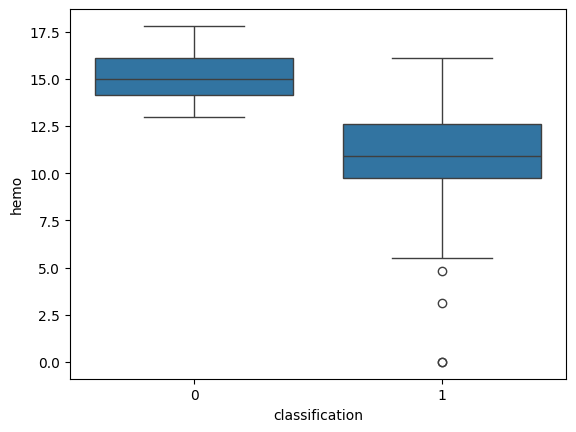

In [ ]:
sns.boxplot(x = user_health_data['classification'],y = user_health_data['hemo'])

In [ ]:
##Dividing data into training and testing set ##########

from sklearn.model_selection import train_test_split
feature_train,feature_val ,target_train, target_val = train_test_split(train_features,train_target,\
test_size = 0.2 , random_state = 1200 , stratify= train_target)

In [ ]:
feature_train.shape , feature_val.shape, target_train.shape ,target_val.shape

((320, 25), (80, 25), (320,), (80,))

In [ ]:
### Emsemble Model ###

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

lr_model = LogisticRegression(max_iter=800)
svm_model = SVC()
knn_model = KNeighborsClassifier()
rf_model = RandomForestClassifier()
dt_model = DecisionTreeClassifier()

ensemble_model = VotingClassifier([('lr',lr_model),
                                  ('svm',svm_model),
                                  ('knn',knn_model),
                                  ('rf',rf_model),
                                  ('dt',dt_model)] , voting = 'hard')

ensemble_model.fit(feature_train,target_train)

VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=800)),
                             ('svm', SVC()), ('knn', KNeighborsClassifier()),
                             ('rf', RandomForestClassifier()),
                             ('dt', DecisionTreeClassifier())])

In [ ]:
with open('ensemblemmodel.pickle','wb') as f:
  pickle.dump(ensemble_model,f)

In [ ]:
from sklearn.metrics import confusion_matrix , f1_score

prediction = ensemble_model.predict(feature_val)
actuals = target_val.to_list()
pd.DataFrame(confusion_matrix(actuals, prediction ) ,columns = ['Predict_0','Predict_1'] , index = ['Actual_0','Actual_1'])



,Predict_0,Predict_1
Actual_0,30,0
Actual_1,1,49


In [ ]:
F1_score = f1_score(actuals, prediction)
F1_score

0.98989898989899